In [1]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt

gmsh.initialize()
gmsh.model.add("t5")

# Filename for saving data
filename = 'Pr7_4Q' 

## We will consider the problem of a long, hollow, thick-cylinder subject to internal pressure, and solve the problem using 2D Linear FEM

### To model the problem, we will consider a cross-section of the cylinder (inner radius 1 and outer radius 2), and model a quadrant of the cross-section for the analysis

In [2]:
Ri, Ro = 10, 15

# Define mesh resolution
lc = 1e-2

# Add vertices of model
gmsh.model.geo.addPoint(Ri, 0, 0, lc, 1)
gmsh.model.geo.addPoint(Ro, 0, lc, 2)
gmsh.model.geo.addPoint(0, Ro, 0, lc, 3)
gmsh.model.geo.addPoint(0, Ri, lc, 4)
gmsh.model.geo.addPoint(0, 0, 0, lc, 5)

# Add lines joining vertices
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addCircleArc(2, 5, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addCircleArc(4, 5, 1, 4)

# Add Curve loop and surface
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

1

### A technique to initiate structured meshes. 
On all lines of the structure, you specify the number of the nodes using the transfinite curve option in gmsh. Then there are other optional points you can provide to get a structured mesh

### Change nx and ny to change the mesh resolution 

In [3]:
nx, ny = 5, 5
gmsh.model.geo.mesh.setTransfiniteCurve(1, nx)
gmsh.model.geo.mesh.setTransfiniteCurve(3, nx)
gmsh.model.geo.mesh.setTransfiniteCurve(2, ny)
gmsh.model.geo.mesh.setTransfiniteCurve(4, ny)
gmsh.model.geo.mesh.setTransfiniteSurface(1)
gmsh.model.geo.mesh.setRecombine(2,1)

gmsh.model.geo.synchronize()

## Add Physical Groupsto apply boundary conditions

gmsh.model.addPhysicalGroup(1, [1], name='DBC1')
gmsh.model.addPhysicalGroup(1, [3], name='DBC2')
gmsh.model.addPhysicalGroup(1, [4], name='NBC')
gmsh.model.addPhysicalGroup(2, [1], name = "Dom")
gmsh.option.setNumber("Mesh.Smoothing", 100)
gmsh.model.mesh.generate(2)

gmsh.model.mesh.refine()
#gmsh.model.mesh.setOrder(2)

gmsh.write("t5.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000123402s, CPU 5.7e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 3.8502e-05s, CPU 9.2e-05s)
Info    : 26 nodes 37 elements
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 60%] Meshing curve 4 order 2
Info    : [ 80%] Meshing surface 1 order 2
Info    : Done meshing order 2 (Wall 0.000164891s, CPU 0.000105s)
Info    : Done refining mesh (Wall 0.000185149s, CPU 0.000118s)
Info    : Writing 't5.msh'...
Info    : Done writing 't5.msh'


In [4]:
gmsh.fltk.run()
gmsh.finalize()

-------------------------------------------------------
Version       : 4.11.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20221221
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


## The latest version of the mesh file from gmsh is hard to decode manually. Meshio, an open-source software does this very easily. I have used this to convert mesh data to a format suitable for input to my code.

https://pypi.org/project/meshio/

In [5]:
mesh = meshio.read("t5.msh")
mesh

<meshio mesh object>
  Number of points: 81
  Number of cells:
    line: 8
    line: 8
    line: 8
    quad: 64
  Cell sets: DBC1, DBC2, NBC, Dom, gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: DBC1, DBC2, NBC, Dom

In [6]:
points = mesh.points
cells = mesh.cells

In [7]:
mesh.cells

[<meshio CellBlock, type: line, num cells: 8, tags: []>,
 <meshio CellBlock, type: line, num cells: 8, tags: []>,
 <meshio CellBlock, type: line, num cells: 8, tags: []>,
 <meshio CellBlock, type: quad, num cells: 64, tags: []>]

In [8]:
eles = None
for ii in cells:
    if ii.type.startswith('triang'):               
        if eles is None:
            eles = np.insert(ii.data,0,ii.data.shape[1],axis=1)
        else:
            eles = np.vstack([eles,np.insert(ii.data,0,ii.data.shape[1],axis=1)])        
    elif ii.type.startswith('quad'):        
        if eles is None:
            eles = np.insert(ii.data,0,ii.data.shape[1],axis=1)
        else:
            if eles.shape[1] < ii.data.shape[1]+1:                
                eles = np.hstack((eles,np.zeros((eles.shape[0],ii.data.shape[1]-eles.shape[1]+1))))
            eles = np.vstack([eles,np.insert(ii.data,0,ii.data.shape[1],axis=1)])        
print(eles)

[[ 4  0  4 43 31]
 [ 4  4  5 41 43]
 [ 4 43 41 32 42]
 [ 4 31 43 42 30]
 [ 4 30 42 46 29]
 [ 4 42 32 44 46]
 [ 4 46 44 33 45]
 [ 4 29 46 45 28]
 [ 4 28 45 49 27]
 [ 4 45 33 47 49]
 [ 4 49 47 34 48]
 [ 4 27 49 48 26]
 [ 4 26 48 51 25]
 [ 4 48 34 50 51]
 [ 4 51 50 23 24]
 [ 4 25 51 24  3]
 [ 4  5  6 54 41]
 [ 4  6  7 52 54]
 [ 4 54 52 35 53]
 [ 4 41 54 53 32]
 [ 4 32 53 57 44]
 [ 4 53 35 55 57]
 [ 4 57 55 36 56]
 [ 4 44 57 56 33]
 [ 4 33 56 60 47]
 [ 4 56 36 58 60]
 [ 4 60 58 37 59]
 [ 4 47 60 59 34]
 [ 4 34 59 62 50]
 [ 4 59 37 61 62]
 [ 4 62 61 21 22]
 [ 4 50 62 22 23]
 [ 4  7  8 65 52]
 [ 4  8  9 63 65]
 [ 4 65 63 38 64]
 [ 4 52 65 64 35]
 [ 4 35 64 68 55]
 [ 4 64 38 66 68]
 [ 4 68 66 39 67]
 [ 4 55 68 67 36]
 [ 4 36 67 71 58]
 [ 4 67 39 69 71]
 [ 4 71 69 40 70]
 [ 4 58 71 70 37]
 [ 4 37 70 73 61]
 [ 4 70 40 72 73]
 [ 4 73 72 19 20]
 [ 4 61 73 20 21]
 [ 4  9 10 75 63]
 [ 4 10  1 11 75]
 [ 4 75 11 12 74]
 [ 4 63 75 74 38]
 [ 4 38 74 77 66]
 [ 4 74 12 13 77]
 [ 4 77 13 14 76]
 [ 4 66 77

In [9]:
# Nodes
nodes_array = np.zeros([points.shape[0], 3])
nodes_array[:, 0] = range(1,points.shape[0]+1)
nodes_array[:, 1:3] = points[:, :2]
nodes_array

# Element data
nmat = 1
els_array = np.zeros([eles.shape[0], eles.shape[1]+1+nmat], dtype=int)
els_array[:, 0] = range(1,eles.shape[0]+1)
els_array[:, 1] = eles[:,0]
els_array[:, 2:eles.shape[1]+1] = eles[:,1::]+1 # add +1 to convert from Python to MATLAB
els_array[:, -1] = 1
els_array

array([[ 1,  4,  1,  5, 44, 32,  1],
       [ 2,  4,  5,  6, 42, 44,  1],
       [ 3,  4, 44, 42, 33, 43,  1],
       [ 4,  4, 32, 44, 43, 31,  1],
       [ 5,  4, 31, 43, 47, 30,  1],
       [ 6,  4, 43, 33, 45, 47,  1],
       [ 7,  4, 47, 45, 34, 46,  1],
       [ 8,  4, 30, 47, 46, 29,  1],
       [ 9,  4, 29, 46, 50, 28,  1],
       [10,  4, 46, 34, 48, 50,  1],
       [11,  4, 50, 48, 35, 49,  1],
       [12,  4, 28, 50, 49, 27,  1],
       [13,  4, 27, 49, 52, 26,  1],
       [14,  4, 49, 35, 51, 52,  1],
       [15,  4, 52, 51, 24, 25,  1],
       [16,  4, 26, 52, 25,  4,  1],
       [17,  4,  6,  7, 55, 42,  1],
       [18,  4,  7,  8, 53, 55,  1],
       [19,  4, 55, 53, 36, 54,  1],
       [20,  4, 42, 55, 54, 33,  1],
       [21,  4, 33, 54, 58, 45,  1],
       [22,  4, 54, 36, 56, 58,  1],
       [23,  4, 58, 56, 37, 57,  1],
       [24,  4, 45, 58, 57, 34,  1],
       [25,  4, 34, 57, 61, 48,  1],
       [26,  4, 57, 37, 59, 61,  1],
       [27,  4, 61, 59, 38, 60,  1],
 

In [10]:
np.savetxt(filename+'_elecon.txt', els_array, fmt="%d")
np.savetxt(filename+'_nodes.txt', nodes_array)

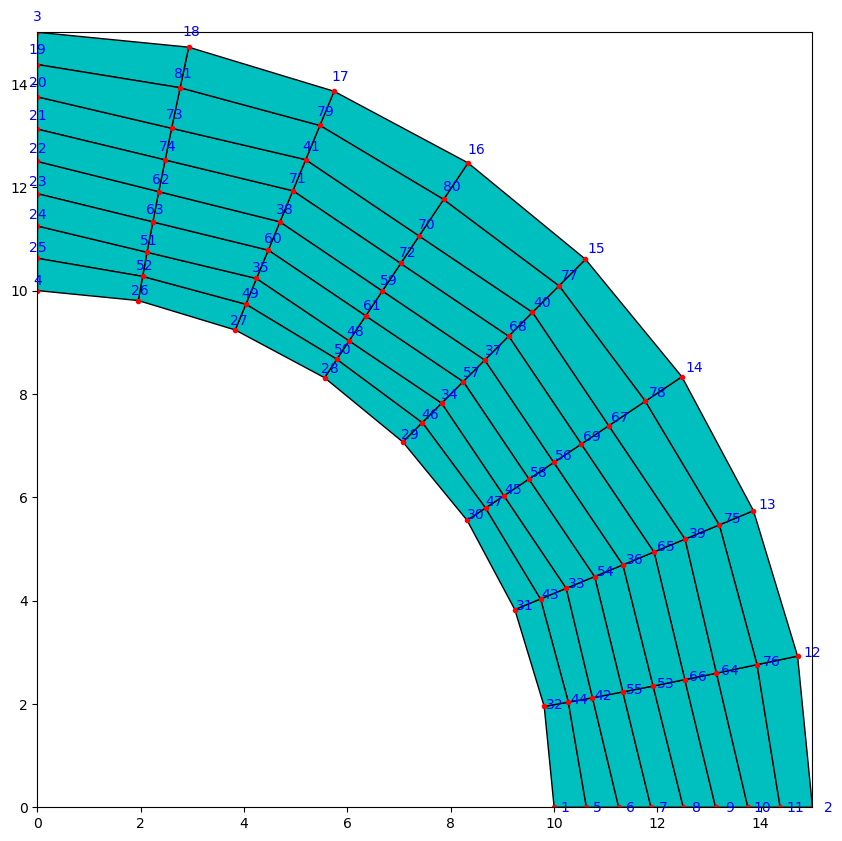

In [11]:
#eles.shape
from matplotlib.patches import Polygon
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, facecolor='w', aspect='equal')

for i in range(eles.shape[0]):
    if eles[i,0] > 4:
        nnodcon = int(np.floor(eles[i,0]/2)+1)        
    else:
        nnodcon = int(np.floor(eles[i,0])+1)      
    ax.add_artist(Polygon(nodes_array[eles[i,1:nnodcon].astype(int),1:3],fc='c',ec='k',closed='True'))

ax.plot(nodes_array[:,1],nodes_array[:,2],'r.')

for i in range(nodes_array.shape[0]): 
    ax.text(nodes_array[i,1]*1.02,nodes_array[i,2]*1.02, int(nodes_array[i,0]), horizontalalignment='center',verticalalignment='center', c='b')

ax.set_xlim(np.min(nodes_array[:,1]),np.max(nodes_array[:,1]))
ax.set_ylim(np.min(nodes_array[:,2]),np.max(nodes_array[:,2]))
#fig.tight_layout()
plt.show()

#nodes_array[i,:]

In [12]:
fields = mesh.field_data
cells_dict = mesh.cells_dict
cell_data_dict = mesh.cell_data_dict

In [13]:
fields

{'DBC1': array([1, 1]),
 'DBC2': array([2, 1]),
 'NBC': array([3, 1]),
 'Dom': array([4, 2])}

In [14]:
print(mesh.cells_dict.keys())
for i in mesh.cells_dict.keys():
    if 'line' in i:
        bound = i

dict_keys(['line', 'quad'])


In [15]:
key = 'DBC1'
ind = fields[key][0]
nod_no = np.unique(cells_dict[bound][ind == cell_data_dict['gmsh:physical'][bound]])
nod_no
dbc1 = np.zeros([len(nod_no),3])
dbc1[:,0] = nod_no+1
dbc1[:,2] = 1

In [16]:
key = 'DBC2'
ind = fields[key][0]
nod_no = np.unique(cells_dict[bound][ind == cell_data_dict['gmsh:physical'][bound]])
nod_no
dbc2 = np.zeros([len(nod_no),3])
dbc2[:,0] = nod_no+1
dbc2[:,1] = 1

In [17]:
dbc = np.unique(np.concatenate((dbc1,dbc2),0),axis=0)
dbc

array([[ 1.,  0.,  1.],
       [ 2.,  0.,  1.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  0.,  1.],
       [ 6.,  0.,  1.],
       [ 7.,  0.,  1.],
       [ 8.,  0.,  1.],
       [ 9.,  0.,  1.],
       [10.,  0.,  1.],
       [11.,  0.,  1.],
       [19.,  1.,  0.],
       [20.,  1.,  0.],
       [21.,  1.,  0.],
       [22.,  1.,  0.],
       [23.,  1.,  0.],
       [24.,  1.,  0.],
       [25.,  1.,  0.]])

In [18]:
key = 'NBC'
ind = fields[key][0]
nod_no = cells_dict[bound][ind == cell_data_dict['gmsh:physical'][bound]]
nod_no+1

array([[ 4, 26],
       [26, 27],
       [27, 28],
       [28, 29],
       [29, 30],
       [30, 31],
       [31, 32],
       [32,  1]])

In [19]:
ms = np.isin(els_array[:,2:nnodcon+1],nod_no+1)
el_no = els_array[np.sum(ms,axis=1)>1,0]
el_no

array([ 1,  4,  5,  8,  9, 12, 13, 16])

In [20]:
print(ms[el_no-1,:].astype('uint8'))

[[1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 0 0 1]]


## Note: I have automated the face detection only for 4-node and 9-node elements. You have to modify this for triangular elements

In [21]:
face = np.ones((len(el_no))).astype(int)
for i in range(len(el_no)):
    indx = np.argwhere(ms[el_no[i]-1,:].astype('uint8')>0)
    if indx[0] == 0 and indx[1] == 1:
        face[i] = 1
    elif indx[0] == 1 and indx[1] == 2:
        face[i] = 2
    elif indx[0] == 2 and indx[1] == 3:
        face[i] = 3
    elif indx[0] == 0 and indx[1] == 3:
        face[i] = 4
face

array([4, 4, 4, 4, 4, 4, 4, 4])

In [22]:
lload = False

if lload is True:
    print('Nodal Loads Applied')
    F_x = 10; F_y = 0; # Assuming that we are solving the scalar field problem
    nod_ld = np.unique(nod_no)
    nbc = np.zeros([len(nod_ld),5])
    nbc[:,0] = 30
    nbc[:,1] = nod_ld+1
    nbc[:,3] = F_x
    nbc[:,4] = F_y # ignore this for scalar problem
else:
    print('Distributed Load Applied')   
    t_x = -2000; t_y = 0; # Assuming that we are solving the scalar field problem
    nbc = np.zeros([len(el_no),5])
    nbc[:,0] = 20
    nbc[:,1] = el_no
    nbc[:,2] = face
    nbc[:,3] = t_y
    nbc[:,4] = t_x # ignore this for scalar problem
nbc

Distributed Load Applied


array([[ 2.0e+01,  1.0e+00,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  4.0e+00,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  5.0e+00,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  8.0e+00,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  9.0e+00,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  1.2e+01,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  1.3e+01,  4.0e+00,  0.0e+00, -2.0e+03],
       [ 2.0e+01,  1.6e+01,  4.0e+00,  0.0e+00, -2.0e+03]])

In [23]:
# Save essential and natural boundary conditions as a txt file if writing to MATLAB. 
# For Python you can use the array as input
np.savetxt(filename+'_dbc.txt', dbc, fmt=("%d","%d","%d"))
np.savetxt(filename+'_nbc.txt', nbc, fmt=("%d", "%d", "%d", "%.4f", "%.4f"))# Save essential and natural boundary conditions as a txt file if writing to MATLAB. 